In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D, GlobalAveragePooling2D,BatchNormalization
from skimage import exposure
from skimage import transform
import os
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Preparing for Data

In [2]:
df = pd.read_excel(r'/Users/apple/Desktop/MATH7243 Machine Learning/final project/Hemorrhage Segmentation Project/hemorrhage_labels_match.xlsx')

#### label the types for each image(the `multi` ones need to be in different combinations, 32 in total)

In [3]:
def nameTypes(row):
    if row['any'] == 0:
        return "normal"
    if row['any'] == 1:
        # single type
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 0) & (row['subdural'] == 0):
            return "epidural"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 0) & (row['subdural'] == 0):
            return "intraparenchymal"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 0) & (row['subdural'] == 0):
            return "intraventricular"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 1) & (row['subdural'] == 0):
            return "subarachnoid"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 0) & (row['subdural'] == 1):
            return "subdural"
        
        # two types together combinations (10 in total)
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 0) & (row['subdural'] == 0):
            return "epi + intrap"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 0) & (row['subdural'] == 0):
            return "epi + intrav"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 1) & (row['subdural'] == 0):
            return "epi + suba"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 0) & (row['subdural'] == 1):
            return "epi + subd"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 0) & (row['subdural'] == 0):
            return "intrap + intrav"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 1) & (row['subdural'] == 0):
            return "intrap + suba"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 0) & (row['subdural'] == 1):
            return "intrap + subd"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 1) & (row['subdural'] == 0):
            return "intrav + suba"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 0) & (row['subdural'] == 1):
            return "intrav + subd"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 1) & (row['subdural'] == 1):
            return "suba + subd"
        
        # three types together combinations (10 in total)
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 0) & (row['subdural'] == 0):
            return "epi + intrap + intrav"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 1) & (row['subdural'] == 0):
            return "epi + intrap + suba"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 0) & (row['subdural'] == 1):
            return "epi + intrap + subd"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 1) & (row['subdural'] == 0):
            return "epi + intrav + suba"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 0) & (row['subdural'] == 1):
            return "epi + intrav + subd"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 1) & (row['subdural'] == 1):
            return "epi + suba + subd"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 1) & (row['subdural'] == 0):
            return "intrap + intrav + suba"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 0) & (row['subdural'] == 1):
            return "intrap + intrav + subd"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 1) & (row['subdural'] == 1):
            return "intrap + suba + subd"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 1) & (row['subdural'] == 1):
            return "intrav + suba + subd"
        
        # four types together combinations (5 in total)
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 1) & (row['subdural'] == 0):
            return "epi + intrap + intrav + suba"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 0) & (row['subdural'] == 1):
            return "epi + intrap + intrav + subd"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 0) & (row['subarachnoid'] == 1) & (row['subdural'] == 1):
            return "epi + intrap + suba + subd"
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 0) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 1) & (row['subdural'] == 1):
            return "epi + intrav + suba + subd"
        if (row['epidural'] == 0) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 1) & (row['subdural'] == 1):
            return "intrap + intrav + suba + subd"
        
        # all types together (1 only)
        if (row['epidural'] == 1) & (row['intraparenchymal'] == 1) & (row['intraventricular'] == 1) & (row['subarachnoid'] == 1) & (row['subdural'] == 1):
            return "all types"
            

In [5]:
df["type"] = df.apply(lambda row: nameTypes(row), axis = 1)

#### Assign numbers to represent each type of hemorrhage(32 in total (starts from 0))   

In [4]:
def assign_num(row):
    if row['type'] == 'epidural':
        return 0
    if row['type'] == 'intraparenchymal':
        return 1
    if row['type'] == 'intraventricular':
        return 2
    if row['type'] == 'subarachnoid':
        return 3
    if row['type'] == 'subdural':
        return 4
    if row['type'] == 'normal':
        return 5
    # two types combinations
    if row['type'] == 'epi + intrap':
        return 6
    if row['type'] == 'epi + intrav':
        return 7
    if row['type'] == 'epi + suba':
        return 8
    if row['type'] == 'epi + subd':
        return 9
    if row['type'] == 'intrap + intrav':
        return 10
    if row['type'] == 'intrap + suba':
        return 11
    if row['type'] == 'intrap + subd':
        return 12
    if row['type'] == 'intrav + suba':
        return 13
    if row['type'] == 'intrav + subd':
        return 14
    if row['type'] == 'suba + subd':
        return 15
    
    # three types combinations
    if row['type'] == 'epi + intrap + intrav':
        return 16
    if row['type'] == 'epi + intrap + suba':
        return 17
    if row['type'] == 'epi + intrap + subd':
        return 18
    if row['type'] == 'epi + intrav + suba':
        return 19
    if row['type'] == 'epi + intrav + subd':
        return 20
    if row['type'] == 'epi + suba + subd':
        return 21
    if row['type'] == 'intrap + intrav + suba':
        return 22
    if row['type'] == 'intrap + intrav + subd':
        return 23
    if row['type'] == 'intrap + suba + subd':
        return 24
    if row['type'] == 'intrav + suba + subd':
        return 25
    
    # four types combinations
    if row['type'] == 'epi + intrap + intrav + suba':
        return 26
    if row['type'] == 'epi + intrap + intrav + subd':
        return 27
    if row['type'] == 'epi + intrap + suba + subd':
        return 28
    if row['type'] == 'epi + intrav + suba + subd':
        return 29
    if row['type'] == 'intrap + intrav + suba + subd':
        return 30
    
    # all types
    if row['type'] == 'all types':
        return 31

In [6]:
df['num_represent'] = df.apply(lambda row: assign_num(row), axis = 1)

#### dictionary for all types with corresponding representing numbers

In [39]:
hemorrhage_type_dict = {
                        0: 'epidural', 
                        1: 'intraparenchymal', 
                        2: 'intraventricular', 
                        3: 'subarachnoid', 
                        4:'subdural',  
                        5: 'normal',
                        6: 'epi + intrap', 
                        7: 'epi + intrav', 
                        8: 'epi + suba', 
                        9: 'epi + subd', 
                        10:'intrap + intrav',  
                        11: 'intrap + suba',
                        12: 'intrap + subd', 
                        13: 'intrav + suba', 
                        14: 'intrav + subd', 
                        15: 'suba + subd', 
                        16:'epi + intrap + intrav',  
                        17: 'epi + intrap + suba',
                        18: 'epi + intrap + subd', 
                        19: 'epi + intrav + suba', 
                        20: 'epi + intrav + subd', 
                        21: 'epi + suba + subd', 
                        22:'intrap + intrav + suba',  
                        23: 'intrap + intrav + subd',
                        24: 'intrap + suba + subd', 
                        25: 'intrav + suba + subd', 
                        26: 'epi + intrap + intrav + suba', 
                        27: 'epi + intrap + intrav + subd', 
                        28:'epi + intrap + suba + subd',  
                        29: 'epi + intrav + suba + subd',
                        30:'intrap + intrav + suba + subd',  
                        31: 'all types',
                       }

We noticed that some data in `hemorrhage-labels` file do not have corresponding images in `brain_window` folder, so we need to delete those datasets by the following function.

#### Delete the ones in `hemorrhage-labels` that do not have corresponding images in `brain_window` folder based on the image IDs


In [3]:
# retrive all the image IDs from `brain_window` directory
image_dir = '/Users/apple/Desktop/MATH7243 Machine Learning/final project/Brain CT Image/after cleaning/brain_window_allTypes'
images = os.listdir(image_dir)

In [4]:
# total number of images in `brain_window` folder
len(images)

112936

In [45]:
# if image id in data is contained in the `image` list, then return 'yes', representing it matches with the image id
def remove_wo_image(row):
    i = row['Image'] + '.jpg'
    if i not in images:
        return 'no'
    else:
        return 'yes'

In [46]:
data['match'] = data.apply(lambda row: remove_wo_image(row), axis = 1)

In [47]:
data[data['match'] == 'yes'].shape

(112936, 12)

# Start from here: try different models for classification

## First Try: with all types (32 in total)

In [2]:
# labels for all data
labels = pd.read_excel(r'/Users/apple/Desktop/MATH7243 Machine Learning/final project/Hemorrhage Segmentation Project/hemorrhage-labels-final.xlsx')

In [6]:
labels.head(10)

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,match,type,num_represent
0,ID_000012eaf,0,0,0,0,0,0,yes,normal,5
1,ID_000039fa0,0,0,0,0,0,0,yes,normal,5
2,ID_00005679d,0,0,0,0,0,0,yes,normal,5
3,ID_00008ce3c,0,0,0,0,0,0,yes,normal,5
4,ID_0000aee4b,0,0,0,0,0,0,yes,normal,5
5,ID_0000ca2f6,0,0,0,0,0,0,yes,normal,5
6,ID_0000f1657,0,0,0,0,0,0,yes,normal,5
7,ID_000178e76,0,0,0,0,0,0,yes,normal,5
8,ID_00019828f,0,0,0,0,0,0,yes,normal,5
9,ID_0001de0e8,0,0,0,0,0,0,yes,normal,5


In [3]:
# All the types
types = labels['type']
typeSet = set(types)
num_labels = len(typeSet)
print(num_labels)
typeSet

32


{'all types',
 'epi + intrap',
 'epi + intrap + intrav',
 'epi + intrap + intrav + suba',
 'epi + intrap + intrav + subd',
 'epi + intrap + suba',
 'epi + intrap + suba + subd',
 'epi + intrap + subd',
 'epi + intrav',
 'epi + intrav + suba',
 'epi + intrav + suba + subd',
 'epi + intrav + subd',
 'epi + suba',
 'epi + suba + subd',
 'epi + subd',
 'epidural',
 'intrap + intrav',
 'intrap + intrav + suba',
 'intrap + intrav + suba + subd',
 'intrap + intrav + subd',
 'intrap + suba',
 'intrap + suba + subd',
 'intrap + subd',
 'intraparenchymal',
 'intrav + suba',
 'intrav + suba + subd',
 'intrav + subd',
 'intraventricular',
 'normal',
 'suba + subd',
 'subarachnoid',
 'subdural'}

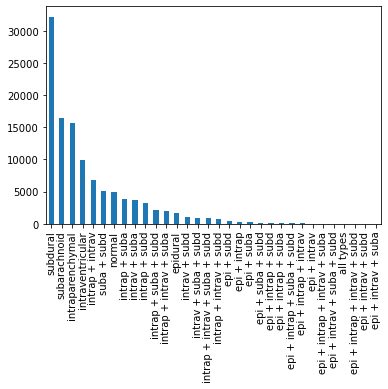

In [7]:
# The distribution of dataset for all different types
labels['type'].value_counts().plot(kind = 'bar')
plt.savefig('distribution.jpg',bbox_inches='tight',dpi = 150)

In [6]:
labels['type'].value_counts()

subdural                         32199
subarachnoid                     16423
intraparenchymal                 15661
intraventricular                  9878
intrap + intrav                   6817
suba + subd                       5082
normal                            5008
intrap + suba                     3932
intrav + suba                     3677
intrap + subd                     3311
intrap + suba + subd              2198
intrap + intrav + suba            1955
epidural                          1693
intrav + subd                     1084
intrav + suba + subd               968
intrap + intrav + suba + subd      871
intrap + intrav + subd             728
epi + subd                         382
epi + intrap                       281
epi + suba                         220
epi + suba + subd                  108
epi + intrap + subd                 93
epi + intrap + suba                 88
epi + intrap + suba + subd          52
epi + intrap + intrav               50
epi + intrav             

In [8]:
labels['type'].value_counts().reset_index().to_csv('detailed_distribution.csv')

We can see that the distribution of dataset for all different types are imbalanced.

In [4]:
file_dir = '/Users/apple/Desktop/MATH7243 Machine Learning/final project/Brain CT Image/after cleaning/brain_window_allTypes/'
suffix = '.jpg'

(512, 512, 3)


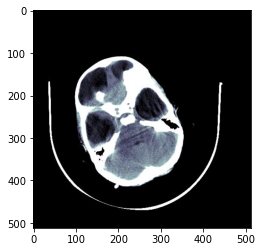

In [5]:
#load sample image
sample = matplotlib.image.imread(file_dir + 'ID_000178e76.jpg')
plt.imshow(sample)
print(sample.shape)

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


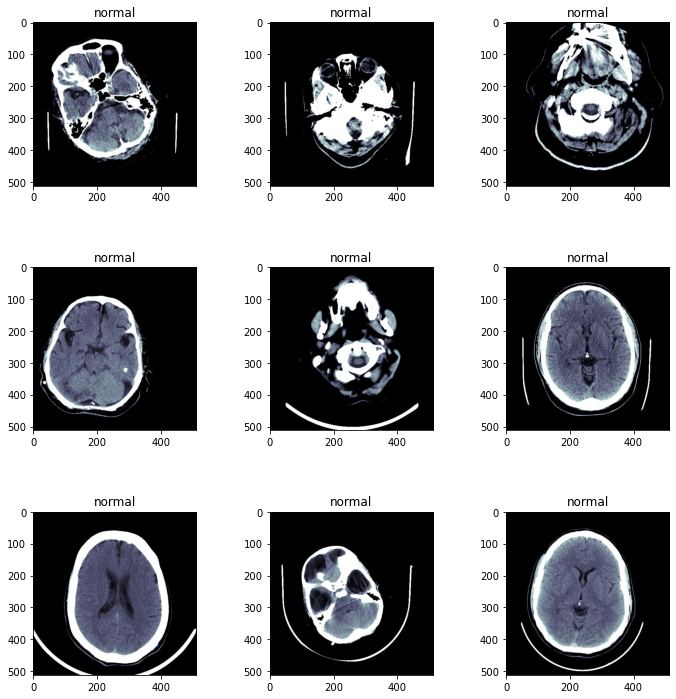

In [9]:
# Load the sample dataset
n_rows = 3
n_cols = 3
plt.figure(figsize=(12,12))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        im = matplotlib.image.imread(file_dir + str(labels.Image.iloc[index])+suffix)
        plt.imshow(im)
        plt.title(labels.type.iloc[index], fontsize=12)
        print(im.shape)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
 
plt.show()

We can see that all the images are in the same size: 512 x 512 x 3, so that we do not need extra work for the images.

### Use 500 for each type of hemorrhage, except for the ones which have less than 500 dataset (will use all). And use 80% as training, 10% as validation, 10% as testing.

In [6]:
# Split the types which have more than 500 dataset and the ones have less than 500
moreThan = []
lessThan = []
for i in typeSet:
    if labels['type'].value_counts()[i] >= 500:
        moreThan.append(i)
    else:
        lessThan.append(i)

In [7]:
# Create a new dataset with selected sub dataset
df = pd.DataFrame()
for i in typeSet:
    if i in moreThan:
        df = df.append(labels[labels['type'] == i].iloc[:500])
    if i in lessThan:
        df = df.append(labels[labels['type'] == i])

In [8]:
# shuffle the dataset
df = shuffle(df)

In [9]:
df.head(10)

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,match,type,num_represent
50968,ID_6c4a37981,1,0,1,1,0,1,yes,intrap + intrav + subd,23
795,ID_00525d936,1,0,0,1,0,0,yes,intraventricular,2
4928,ID_0201291bb,1,0,0,0,1,1,yes,suba + subd,15
6677,ID_03e6d389d,1,0,0,0,0,1,yes,subdural,4
291,ID_001d230d4,0,0,0,0,0,0,yes,normal,5
8270,ID_077c4dd9d,1,0,0,0,1,1,yes,suba + subd,15
70204,ID_99daa26f1,1,0,1,1,0,1,yes,intrap + intrav + subd,23
31003,ID_3cf0dc989,1,1,0,0,0,0,yes,epidural,0
40137,ID_52b68ab9d,1,0,1,1,0,1,yes,intrap + intrav + subd,23
45894,ID_602d1928a,1,1,0,0,0,1,yes,epi + subd,9


In [10]:
df.shape

(9951, 10)

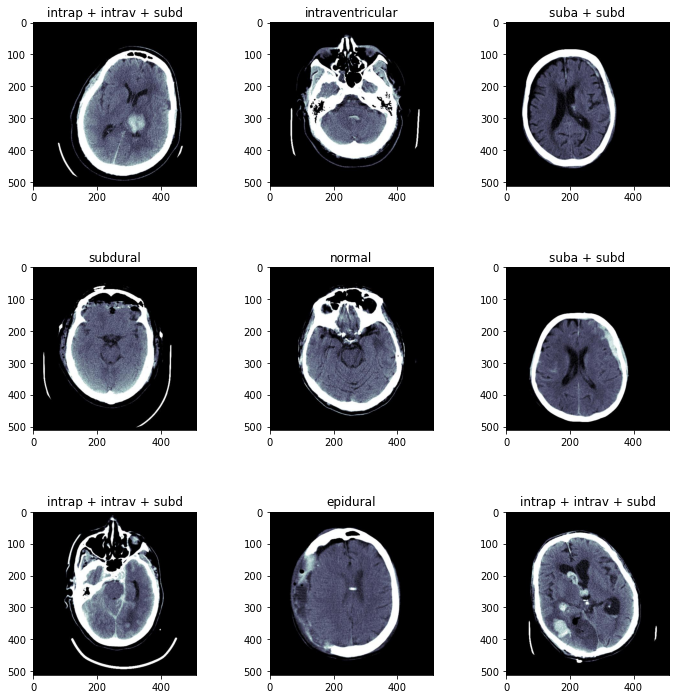

In [11]:
# Load sample dataset
n_rows = 3
n_cols = 3
plt.figure(figsize=(12,12))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        im = matplotlib.image.imread(file_dir + str(df.Image.iloc[index])+suffix)
        plt.imshow(im)
        plt.title(df.type.iloc[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
 
plt.show()

(350, 350, 3)


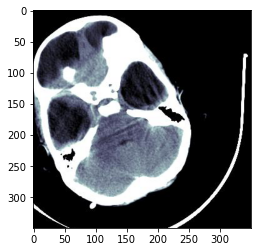

In [12]:
# Try croping the original image
sample = matplotlib.image.imread(file_dir + 'ID_000178e76.jpg')
crop = sample[100:450, 100:450, :]
plt.imshow(crop)  
print(crop.shape)

(224, 224, 3)


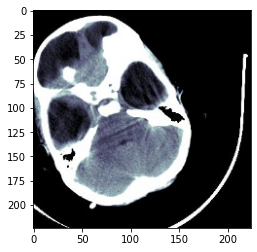

In [44]:
# Try resize the sample image
image_resize = transform.resize(crop, (224, 224))
plt.imshow(image_resize)
print(image_resize.shape)

In [21]:
# Append all the data with croping and resizing from 512 x 512 -> 224 x 224, 
# since some pretrained model requires 224 x 224 input size
data = []
data_x = df.Image
for image in data_x:
    image_name = matplotlib.image.imread(file_dir + str(image)+suffix)
    crop  = image_name[100:450, 100:450, :] #crop the image
    image_resize = transform.resize(crop, (224, 224)) #resize the image
    data.append(image_resize)
    

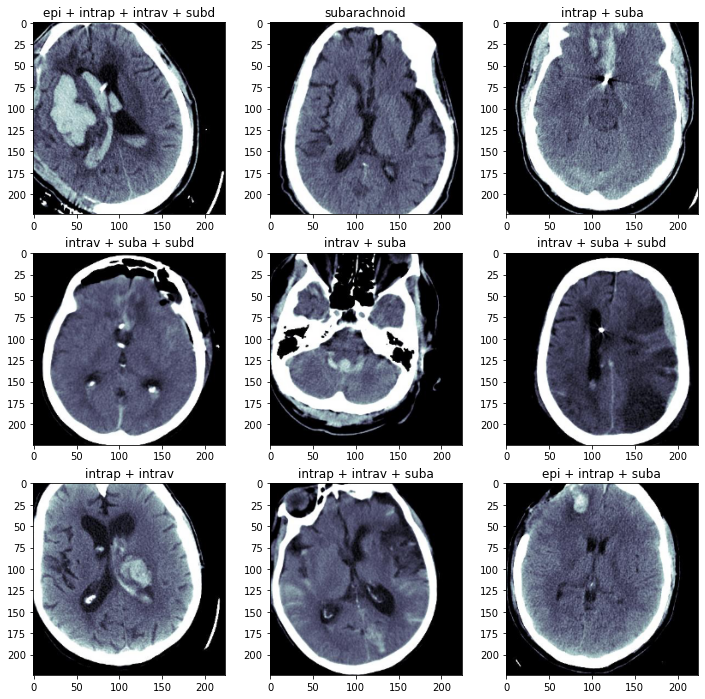

In [22]:
# Plot sample images with resizing and croping
plt.figure(figsize=(12, 12))
for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(data[index])
    plt.title(df.type.iloc[index])

plt.show()

In [23]:
# x data
Train = np.array(data)
print(Train.shape)
# y data
y = np.array(df['num_represent'])
print(y.shape)

(9951, 224, 224, 3)
(9951,)


In [24]:
# Split the data: 80% training data, 20% testing and validation
x_train, x_rem, y_train, y_rem = train_test_split(Train, y, train_size=0.8, random_state=42)

print("x_train", x_train.shape)
print("x_rem", x_rem.shape) #remaining(validation + test)
print("y_train", y_train.shape)
print("y_rem", y_rem.shape)

x_train (7960, 224, 224, 3)
x_rem (1991, 224, 224, 3)
y_train (7960,)
y_rem (1991,)


In [25]:
# Split the remaining data: 50% testing and 50% validation
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size = 0.5, random_state = 42)

print("x_val", x_val.shape)
print("x_test", x_test.shape) 
print("y_val", y_val.shape)
print("y_test", y_test.shape)

x_val (995, 224, 224, 3)
x_test (996, 224, 224, 3)
y_val (995,)
y_test (996,)


In [26]:
# Normalize the data
X_train = x_train/255
X_val = x_val/255
X_test = x_test/255

# Convert Y values into one-hot-encoding
Y_train = to_categorical(y_train, num_labels)
Y_val = to_categorical(y_val, num_labels)
Y_test = to_categorical(y_test, num_labels)

print("x_train", X_train.shape)
print("x_test", X_test.shape)
print("x_val", X_val.shape)
print("y_train", Y_train.shape)
print("y_test", Y_test.shape)
print("y_val", Y_val.shape)

x_train (7960, 224, 224, 3)
x_test (996, 224, 224, 3)
x_val (995, 224, 224, 3)
y_train (7960, 32)
y_test (996, 32)
y_val (995, 32)


In [27]:
# calculate the class weights
from sklearn.utils import class_weight

In [28]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.6265743073047859,
 1: 0.625,
 2: 0.6141975308641975,
 3: 0.6329516539440203,
 4: 0.6172456575682382,
 5: 0.6067073170731707,
 6: 1.072198275862069,
 7: 7.537878787878788,
 8: 1.4378612716763006,
 9: 0.8291666666666667,
 10: 0.6052311435523114,
 11: 0.625,
 12: 0.625,
 13: 0.6067073170731707,
 14: 0.6141975308641975,
 15: 0.6528871391076115,
 16: 6.067073170731708,
 17: 3.4075342465753424,
 18: 3.6050724637681157,
 19: 22.613636363636363,
 20: 16.583333333333332,
 21: 2.794943820224719,
 22: 0.6444300518134715,
 23: 0.621875,
 24: 0.6313451776649747,
 25: 0.6096813725490197,
 26: 7.7734375,
 27: 14.632352941176471,
 28: 5.9226190476190474,
 29: 9.95,
 30: 0.6313451776649747,
 31: 14.632352941176471}

## Model 1: CNN Model From Lab 5 

In [71]:
model = Sequential()

model.add(Conv2D(32, (7,7),
                 padding='valid',
                 input_shape=(224, 224,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_labels, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 218, 218, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 89888)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1

In [72]:
epochs = 20

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    validation_data=(X_val, Y_val), class_weight = class_weights
                   )

Train on 7960 samples, validate on 995 samples
Epoch 1/20
7960/7960 [==============================] - 240s 30ms/sample - loss: 3.4692 - accuracy: 0.0249 - val_loss: 3.2400 - val_accuracy: 0.0513
Epoch 2/20
7960/7960 [==============================] - 212s 27ms/sample - loss: 3.4664 - accuracy: 0.0271 - val_loss: 3.2401 - val_accuracy: 0.0513
Epoch 3/20
7960/7960 [==============================] - 203s 26ms/sample - loss: 3.4664 - accuracy: 0.0446 - val_loss: 3.2397 - val_accuracy: 0.0513
Epoch 4/20
7960/7960 [==============================] - 202s 25ms/sample - loss: 3.4664 - accuracy: 0.0421 - val_loss: 3.2395 - val_accuracy: 0.0241
Epoch 5/20
7960/7960 [==============================] - 202s 25ms/sample - loss: 3.4664 - accuracy: 0.0411 - val_loss: 3.2393 - val_accuracy: 0.0563
Epoch 6/20
7960/7960 [==============================] - 203s 26ms/sample - loss: 3.4665 - accuracy: 0.0372 - val_loss: 3.2394 - val_accuracy: 0.0563
Epoch 7/20
7960/7960 [==============================] - 200

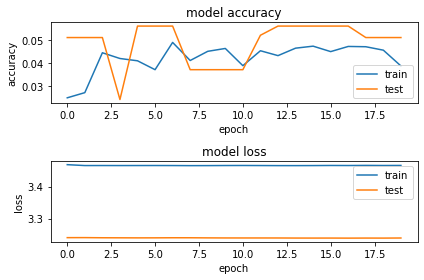

In [73]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [75]:
model.evaluate(X_test, Y_test)

996/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[3.4541971329225594, 0.059236947]

The accuracy is **0.059236947** for testing data after 20 epochs, which is very low.

## Model 2: ResNet50 Model

In [29]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [30]:
base_model = ResNet50(include_top = False, pooling ="avg", weights = "imagenet", input_shape = (224, 224, 3))
flat = Flatten()(base_model.output)
output = Dense(num_labels, activation="softmax")(flat)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [31]:
# Do not train the layers in ResNet50
for layer in base_model.layers:
    layer.trainable = False

In [32]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         fill_mode="nearest")

In [33]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = "adam", metrics=['accuracy'])

In [34]:
epochs = 10
history = model.fit(aug.flow(X_train, y_train),
                    epochs=epochs, 
                    validation_data=(X_val, y_val), class_weight = class_weights
                   )

Train for 249 steps, validate on 995 samples
Epoch 1/10
249/249 [==============================] - 1019s 4s/step - loss: 3.0875 - accuracy: 0.1253 - val_loss: 4.0450 - val_accuracy: 0.0503
Epoch 2/10
249/249 [==============================] - 1028s 4s/step - loss: 2.7926 - accuracy: 0.1763 - val_loss: 4.1124 - val_accuracy: 0.0040
Epoch 3/10
249/249 [==============================] - 1038s 4s/step - loss: 2.6623 - accuracy: 0.2043 - val_loss: 4.3653 - val_accuracy: 0.0503
Epoch 4/10
249/249 [==============================] - 1008s 4s/step - loss: 2.5991 - accuracy: 0.2157 - val_loss: 4.4677 - val_accuracy: 0.0503
Epoch 5/10
249/249 [==============================] - 1029s 4s/step - loss: 2.5478 - accuracy: 0.2305 - val_loss: 4.5474 - val_accuracy: 0.0503
Epoch 6/10
249/249 [==============================] - 997s 4s/step - loss: 2.5008 - accuracy: 0.2448 - val_loss: 4.6660 - val_accuracy: 0.0503
Epoch 7/10
249/249 [==============================] - 987s 4s/step - loss: 2.4714 - accuracy

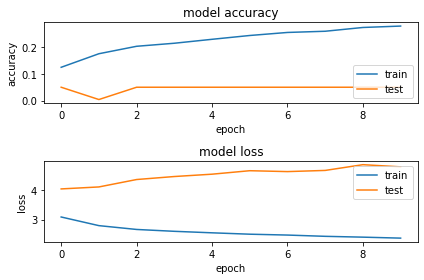

In [37]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [36]:
model.evaluate(X_test, y_test)

996/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[4.237185493530519, 0.052208837]

The accuracy for testing data is **0.052208837**.

## Model 3: Decision Tree Model

In [50]:
from sklearn.tree import DecisionTreeClassifier

#### Decision tree expects a 2d array of data, need to convert our 4D data into 2D

In [51]:
# Convert X_train
nsamples, nx, ny, nrgb = X_train.shape
X_train2 = X_train.reshape((nsamples,nx*ny*nrgb))
X_train2.shape

(7960, 150528)

In [52]:
# Convert X_val
nsamples1, nx1, ny1, nrgb1 = X_val.shape
X_val2 = X_val.reshape((nsamples1,nx1*ny1*nrgb1))
X_val2.shape

(995, 150528)

In [53]:
# Convert X_test
nsamples2, nx2, ny2, nrgb2 = X_test.shape
X_test2 = X_test.reshape((nsamples2,nx2*ny2*nrgb2))
X_test2.shape

(996, 150528)

In [54]:
#build decision tree model
dtree = DecisionTreeClassifier()
dtree.fit(X_train2, y_train)

DecisionTreeClassifier()

In [55]:
from sklearn.metrics import accuracy_score

In [56]:
# Predicted result for validation data
y_pred=dtree.predict(X_val2)

In [57]:
accuracy_score(y_pred,y_val)

0.10452261306532663

The accuracy for validation data is about **0.1045**, which is a little bit higher than the above two models.

In [59]:
# Predicted result for testing data
y_predTest=dtree.predict(X_test2)

In [60]:
accuracy_score(y_predTest,y_test)

0.0893574297188755

The accuracy for testing data is about **0.08936**.

#### In conclusion, after trying three different models, we can see that the accuracy for Decision Tree Model is the highest among the three models.

# Second Try: only use binary type (without multi)

In [40]:
# Print out the distribution for dataset
for i in range(6):
 print(labels['num_represent'].value_counts()[i],hemorrhage_type_dict.get(i))

1693 epidural
15661 intraparenchymal
9878 intraventricular
16423 subarachnoid
32199 subdural
5008 normal


<AxesSubplot:>

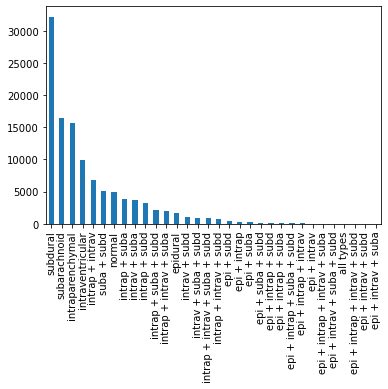

In [41]:
labels['type'].value_counts().plot(kind = 'bar')

#### We can see that the distribution is imbalanced. Only use 1600 dataset for each kind.

In [5]:
# Use 1600 dataset for each kind
binary = pd.DataFrame()
for i in range(6):
    df = labels[labels['num_represent'] == i].sample(1600)
    binary = binary.append(df)

In [6]:
# shuffle the dataset
binary = shuffle(binary)

In [7]:
binary

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,match,type,num_represent
1786,ID_00b40c017,0,0,0,0,0,0,yes,normal,5
56412,ID_79310ac65,1,0,0,0,1,0,yes,subarachnoid,3
4347,ID_01c0a6dab,0,0,0,0,0,0,yes,normal,5
9394,ID_0a39a7d4f,1,1,0,0,0,0,yes,epidural,0
4411,ID_01c70ab98,0,0,0,0,0,0,yes,normal,5
...,...,...,...,...,...,...,...,...,...,...
510,ID_0034ee0c2,0,0,0,0,0,0,yes,normal,5
2411,ID_00f570ea0,0,0,0,0,0,0,yes,normal,5
61596,ID_858c65aa2,1,0,0,0,1,0,yes,subarachnoid,3
69490,ID_983354981,1,0,0,1,0,0,yes,intraventricular,2


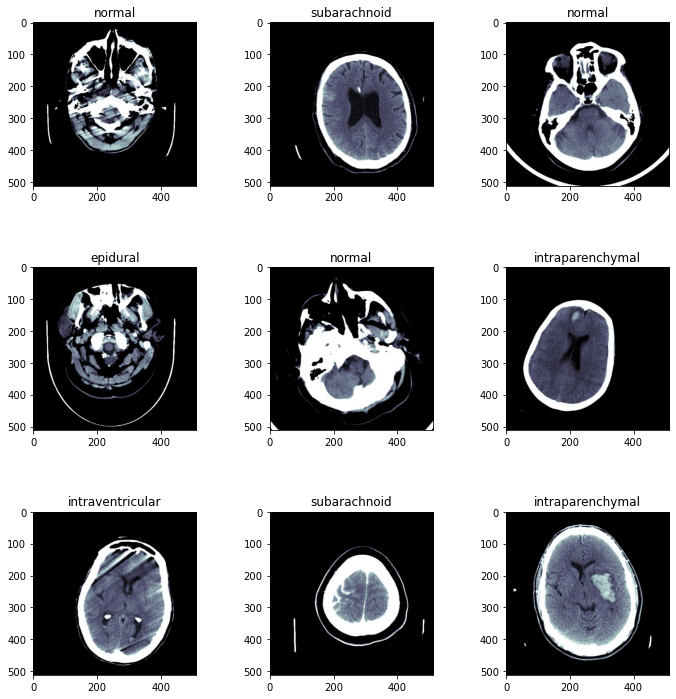

In [8]:
# Plot the original sample dataset
n_rows = 3
n_cols = 3
plt.figure(figsize=(12,12))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        im = matplotlib.image.imread(file_dir + str(binary.Image.iloc[index])+suffix)
        plt.imshow(im)
        plt.title(binary.type.iloc[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
 
plt.show()

In [9]:
# Append all the data with croping and resizing from 512 x 512 -> 224 x 224, 
# since some pretrained model requires 224 x 224 input size
bina = []
bina_x = binary.Image
for image in bina_x:
    image_name = matplotlib.image.imread(file_dir + str(image)+suffix)
    crop  = image_name[100:450, 100:450, :] #crop the image
    image_resize = transform.resize(crop, (224, 224)) #resize the image
    bina.append(image_resize)

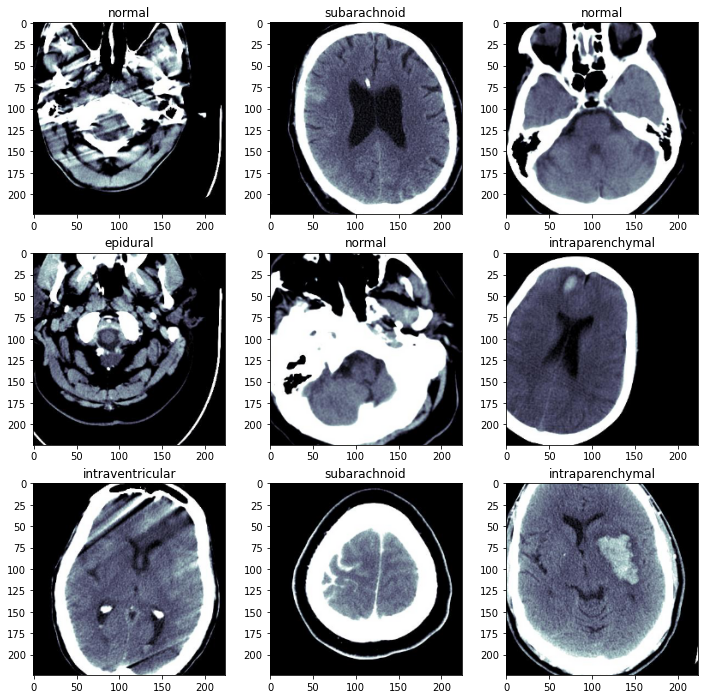

In [10]:
# Plot the sample dataset after croping and resizing
plt.figure(figsize=(12, 12))
for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(bina[index])
    plt.title(binary.type.iloc[index])

plt.show()

In [11]:
# x data
Train = np.array(bina)
print(Train.shape)
# y data
y = np.array(binary['num_represent'])
print(y.shape)

(9600, 224, 224, 3)
(9600,)


In [12]:
# Split the data: 80% as training data, 20% testing and validation
x_train, x_rem, y_train, y_rem = train_test_split(Train, y, train_size=0.8, random_state=42)

print("x_train", x_train.shape)
print("x_rem", x_rem.shape) #remaining(validation + test)
print("y_train", y_train.shape)
print("y_rem", y_rem.shape)

x_train (7680, 224, 224, 3)
x_rem (1920, 224, 224, 3)
y_train (7680,)
y_rem (1920,)


In [13]:
# Split the remaining data: 50% as validation data and 50% as testing data
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size = 0.5, random_state =42)

print("x_val", x_val.shape)
print("x_test", x_test.shape) 
print("y_val", y_val.shape)
print("y_test", y_test.shape)

x_val (960, 224, 224, 3)
x_test (960, 224, 224, 3)
y_val (960,)
y_test (960,)


In [14]:
# number of labels
num_labels = len(set(binary['type']))
num_labels

6

In [16]:
# Normalize the data
X_train = x_train/255
X_val = x_val/255
X_test = x_test/255

# Convert Y values into one-hot-encoding
Y_train = to_categorical(y_train, num_labels)
Y_val = to_categorical(y_val, num_labels)
Y_test = to_categorical(y_test, num_labels)

print("x_train", X_train.shape)
print("x_test", X_test.shape)
print("x_val", X_val.shape)
print("y_train", Y_train.shape)
print("y_test", Y_test.shape)
print("y_val", Y_val.shape)

x_train (7680, 224, 224, 3)
x_test (960, 224, 224, 3)
x_val (960, 224, 224, 3)
y_train (7680, 6)
y_test (960, 6)
y_val (960, 6)


In [15]:
# calculate the class weights
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.9876543209876543,
 1: 0.9984399375975039,
 2: 1.0078740157480315,
 3: 1.0142630744849446,
 4: 1.0031347962382444,
 5: 0.9891808346213292}

## Model 1: CNN Model in Lab5 

In [29]:
model = Sequential()

model.add(Conv2D(32, (7,7),
                 padding='valid',
                 input_shape=(224, 224,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_labels, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 218, 218, 32)      4736      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 107, 107, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 89888)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [30]:
epochs =20

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    validation_data=(X_val, Y_val), class_weight = class_weights
                   )


Train on 7680 samples, validate on 960 samples
Epoch 1/20
7680/7680 [==============================] - 199s 26ms/sample - loss: 1.7930 - accuracy: 0.1565 - val_loss: 1.7921 - val_accuracy: 0.1823
Epoch 2/20
7680/7680 [==============================] - 192s 25ms/sample - loss: 1.7922 - accuracy: 0.1607 - val_loss: 1.7928 - val_accuracy: 0.1823
Epoch 3/20
7680/7680 [==============================] - 188s 25ms/sample - loss: 1.7920 - accuracy: 0.1582 - val_loss: 1.7929 - val_accuracy: 0.1677
Epoch 4/20
7680/7680 [==============================] - 190s 25ms/sample - loss: 1.7920 - accuracy: 0.1565 - val_loss: 1.7925 - val_accuracy: 0.1823
Epoch 5/20
7680/7680 [==============================] - 189s 25ms/sample - loss: 1.7920 - accuracy: 0.1592 - val_loss: 1.7927 - val_accuracy: 0.1677
Epoch 6/20
7680/7680 [==============================] - 190s 25ms/sample - loss: 1.7919 - accuracy: 0.1668 - val_loss: 1.7929 - val_accuracy: 0.1479
Epoch 7/20
7680/7680 [==============================] - 190

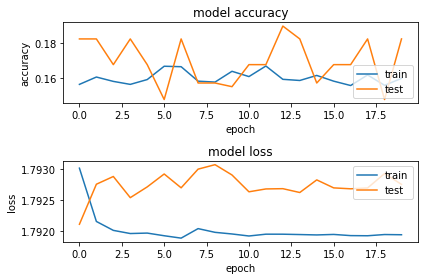

In [31]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [32]:
model.evaluate(X_test, Y_test)

960/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.7918238282203673, 0.165625]

The accuracy for testing data is  **0.165625**.

## Model 2: ResNet50 Model 

In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [18]:
base_model = ResNet50(include_top = False, pooling ="avg", weights = "imagenet", input_shape = (224, 224, 3))
flat = Flatten()(base_model.output)
output = Dense(num_labels, activation="softmax")(flat)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
# Do not train layers in ResNet50
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         fill_mode="nearest")

In [22]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = "adam", metrics=['accuracy'])

In [23]:
epochs = 10

history = model.fit(aug.flow(X_train, y_train),epochs=epochs, 
                    validation_data=(X_val, y_val), class_weight = class_weights)

Train for 240 steps, validate on 960 samples
Epoch 1/10
240/240 [==============================] - 973s 4s/step - loss: 1.6503 - accuracy: 0.3337 - val_loss: 2.2652 - val_accuracy: 0.1594
Epoch 2/10
240/240 [==============================] - 989s 4s/step - loss: 1.4943 - accuracy: 0.4111 - val_loss: 2.2327 - val_accuracy: 0.1750
Epoch 3/10
240/240 [==============================] - 992s 4s/step - loss: 1.4424 - accuracy: 0.4401 - val_loss: 2.3616 - val_accuracy: 0.1750
Epoch 4/10
240/240 [==============================] - 926s 4s/step - loss: 1.4145 - accuracy: 0.4483 - val_loss: 2.3687 - val_accuracy: 0.1750
Epoch 5/10
240/240 [==============================] - 914s 4s/step - loss: 1.3962 - accuracy: 0.4604 - val_loss: 2.4348 - val_accuracy: 0.1750
Epoch 6/10
240/240 [==============================] - 912s 4s/step - loss: 1.3824 - accuracy: 0.4694 - val_loss: 2.5102 - val_accuracy: 0.1750
Epoch 7/10
240/240 [==============================] - 914s 4s/step - loss: 1.3532 - accuracy: 0.4

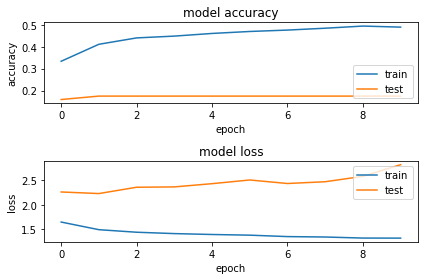

In [24]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [25]:
model.evaluate(X_test, y_test)

960/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.874024756749471, 0.14166667]

The accuracy for testing data is **0.14166667**.

## Model 3: Decision Tree Model

#### Decision tree expects a 2d array of data, need to convert our 4D data into 2D

In [33]:
# Convert for X_train
nsamples, nx, ny, nrgb = X_train.shape
X_train2 = X_train.reshape((nsamples,nx*ny*nrgb))
X_train2.shape

(7680, 150528)

In [34]:
# Convert for X_val
nsamples1, nx1, ny1, nrgb1 = X_val.shape
X_val2 = X_val.reshape((nsamples1,nx1*ny1*nrgb1))
X_val2.shape

(960, 150528)

In [35]:
# Convert for X_test
nsamples2, nx2, ny2, nrgb2 = X_test.shape
X_test2 = X_test.reshape((nsamples2,nx2*ny2*nrgb2))
X_test2.shape

(960, 150528)

In [38]:
#build decision tree model
dtree = DecisionTreeClassifier()
dtree.fit(X_train2, y_train)

DecisionTreeClassifier()

In [39]:
# Predicted result for validation data
y_pred=dtree.predict(X_val2)

In [40]:
accuracy_score(y_pred,y_val)

0.26458333333333334

The accuracy for validation data is **0.26458333333333334**.

In [41]:
# Predicted result for testing data
y_predTest=dtree.predict(X_test2)

In [42]:
accuracy_score(y_predTest,y_test)

0.25

The accuracy for testing data is **0.25**.

#### In conclusion, after trying three different models, we can see that the accuracy for Decision Tree Model is the highest among the three models. In addtion, the results in second try (without multi) are better than the ones in first try (all types).